In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
# create engine to hawaii.sqlite
engine = create_engine(r"sqlite:///C:/Users/awais/Desktop/Statistical test/New folder/hawaii.sqlite")

In [17]:
Base = automap_base()


Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

C:\Users\awais\AppData\Local\Temp\ipykernel_2796\421411489.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [18]:

print(Base.classes.keys())

['measurement', 'station']


In [19]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the result
print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


Date one year ago: 2016-08-23 00:00:00


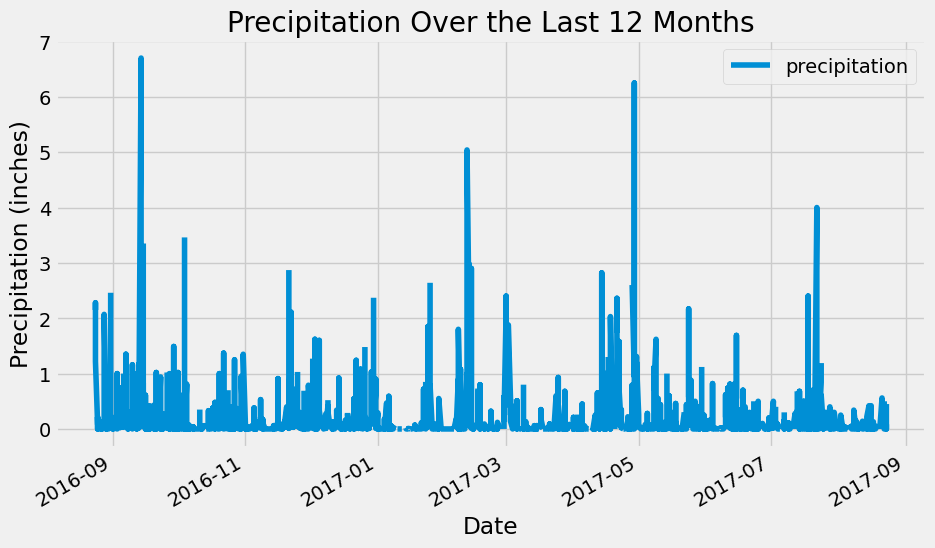

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
 
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date - timedelta(days=365)
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df = precipitation_df.sort_values(by='date')


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', kind='line', figsize=(10,6))
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

# Show the plot
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,date,precipitation
count,2223,2015.000000
mean,2017-02-16 18:54:53.927125248,0.176462
min,2016-08-24 00:00:00,0.000000
25%,2016-11-19 00:00:00,0.000000
50%,2017-02-15 00:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.460288


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the result
print(f"The total number of stations in the dataset is: {total_stations}")


The total number of stations in the dataset is: 9


In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.id).label('count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)

# Print the result
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]  # Access the station ID
print(f"Most active station ID: {most_active_station_id}")
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label('lowest_temp'),
        func.max(Measurement.tobs).label('highest_temp'),
        func.avg(Measurement.tobs).label('average_temp')
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

# Extract the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]

# Print the results
print(f"Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Most active station ID: USC00519281
Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


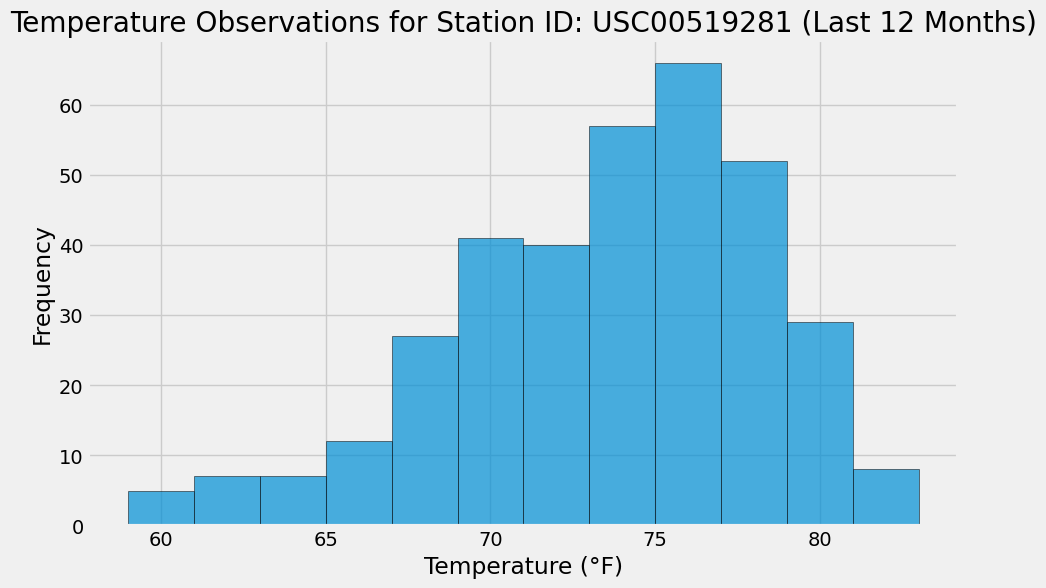

In [30]:
# Using the most active station id
last_year_temps = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert results to a list
temperature_data = [temp[0] for temp in last_year_temps]
plt.figure(figsize=(10, 6))
plt.hist(temperature_data, bins=12, edgecolor='black', alpha=0.7)

# Add labels and title
plt.title(f"Temperature Observations for Station ID: {most_active_station_id} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")

# Show the plot
plt.show()

# Close Session

In [31]:
# Close Session
session.close()